# 0. Import required libraries & preprocesses

In [1]:
# Import all the required libraries
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import folium as fl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the custom palette
custom_palette = ['#f3e13c', '#3295b2', '#d12271', '#2c823a', '#68337b', '#dc6228', '#e8c7d4']
#Suffle the palette
suffled_palette = custom_palette[:]
random.shuffle(suffled_palette)

# Create a continuous colormap
continuous_cmap = LinearSegmentedColormap.from_list("custom_cmap", suffled_palette, N=100)
def clean_and_process_data(df):
    
    # Delete nulls if it is necessary
    if df.isnull().sum().sum() > 0:
        df = df.dropna()
    
    # Transform data usig pandas vector operations
    if 'country' in df.columns:
        df['country'] = df['country'].str.lower().str.strip()
    elif 'name' in df.columns:
        df['name'] = df['name'].str.lower().str.strip()
    
    # Data normalisation with StandardScaler de sklearn
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    return df

# 1. Import data and basic EDA

In [2]:
# Read data
# Read the CSV file into a DataFrame, handling missing values
countries = pd.read_csv('../data/Country-data.csv', na_values=["", "NA"])


The dataset contains information on 167 countries, with 10 key indicators, including child mortality, exports, health expenditure, imports, income, inflation, life expectancy, fertility rate, and GDP per capita. All columns are complete, with no missing values.

Epecifically including the following variables:

- **country**: Name of the country
- **child_mort**: Death of children under 5 years of age per 1,000 live births
- **exports**: Exports of goods and services per capita, given as a percentage of the GDP per capita
- **health**: Total health spending per capita, given as a percentage of GDP per capita
- **imports**: Imports of goods and services per capita, given as a percentage of the GDP per capita
- **income**: Net income per person
- **inflation**: The measurement of the annual growth rate of prices
- **life_expec**: The average number of years a newborn child would live if the current mortality patterns remain the same
- **total_fer**: The number of children that would be born to each woman if the current age-fertility rates remain the same
- **gdpp**: The GDP per capita, calculated as the total GDP divided by the total population.

Within the variables health expenditure, on average, represents 6.8%, with minimun of 1.8% and maximum of 17.9% of GDP and life expectancy averages around 70.5 years, with a minimum of 32.1 and a maximum of 82.8 years. Countries' income levels show large disparities, with GDP per capita ranging from as low as $231 to $125,000. Inflation rates are also highly variable, from -4.21% to 104%.

# 2. Objective of analysis and justification of selected variables

The objective of the proposed clustering analysis is to evaluate how different economic and health factors cluster among various countries to better understand the relationship between citizens' personal and general economy, health investment, and its effects on life expectancy. This analysis could reveal patterns that help identify groups of countries with similar economic and health characteristics, which is useful for policy formulation and resource allocation.

Several studies demonstrate that personal economy and state investment in health have effects on life expectancy. There are various publications on this topic, with some of the most well-known being by the economic and health data analyst and communicator, as seen in references: TedTalks. (n.d.). Gapminder is a website that allows interactive data analysis around the economy and health to understand the effects of their relationships.

The variables selected include life expectancy, health expenditure, income, inflation, and GDP per capita, with the aim of analyzing the influence of personal and general economy on health investment and its effects on life expectancy.

Justification for variable selection:

**Life Expectancy (life_expec):** It is a key public health indicator that reflects the overall impact of health conditions on the population. It is a common target variable to understand the effects of other economic and social factors.

**Health Expenditure per Capita (health):** Represents the health investment per capita as a percentage of GDP. This variable allows analyzing how health investment affects or correlates with life expectancy and other economic indicators.

**Income (income):** The average income of the population is an indicator of economic prosperity and can influence the ability to access quality health services, adequate nutrition, and other essential factors for a long and healthy life.

**Inflation (inflation):** An economic indicator that can have a direct impact on citizens' purchasing power and, therefore, on their ability to maintain a healthy standard of living. High inflation can erode purchasing power, affecting access to necessary goods and services.

**GDP per Capita (gdpp):** Serves as a measure of a country’s overall economic level. A high GDP per capita is often associated with better health infrastructure, greater investment in health services, and better overall health outcomes.

# 3. Acurated Exploratory Data Analysis

In [3]:

# Selecting the variables
countries_select = countries[["life_expec", "health", "income", "inflation", "gdpp"]].copy()

# Cleaning and processing data
countries_norm = clean_and_process_data(countries_select)

# Summary of the data
countries_norm.describe()



,life_expec,health,income,inflation,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,3.696311e-16,5.504579e-16,-7.977650e-17,-1.063687e-17,5.850277e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-4.337186e+00,-1.827827e+00,-8.603259e-01,-1.137852e+00,-6.968005e-01
25%,-5.927576e-01,-6.922106e-01,-7.174558e-01,-5.666409e-01,-6.366596e-01
50%,2.869576e-01,-1.810007e-01,-3.738080e-01,-2.269504e-01,-4.544309e-01
75%,7.042584e-01,6.515412e-01,2.942370e-01,2.816364e-01,5.942100e-02
max,1.380962e+00,4.047436e+00,5.611542e+00,9.129718e+00,5.036507e+00


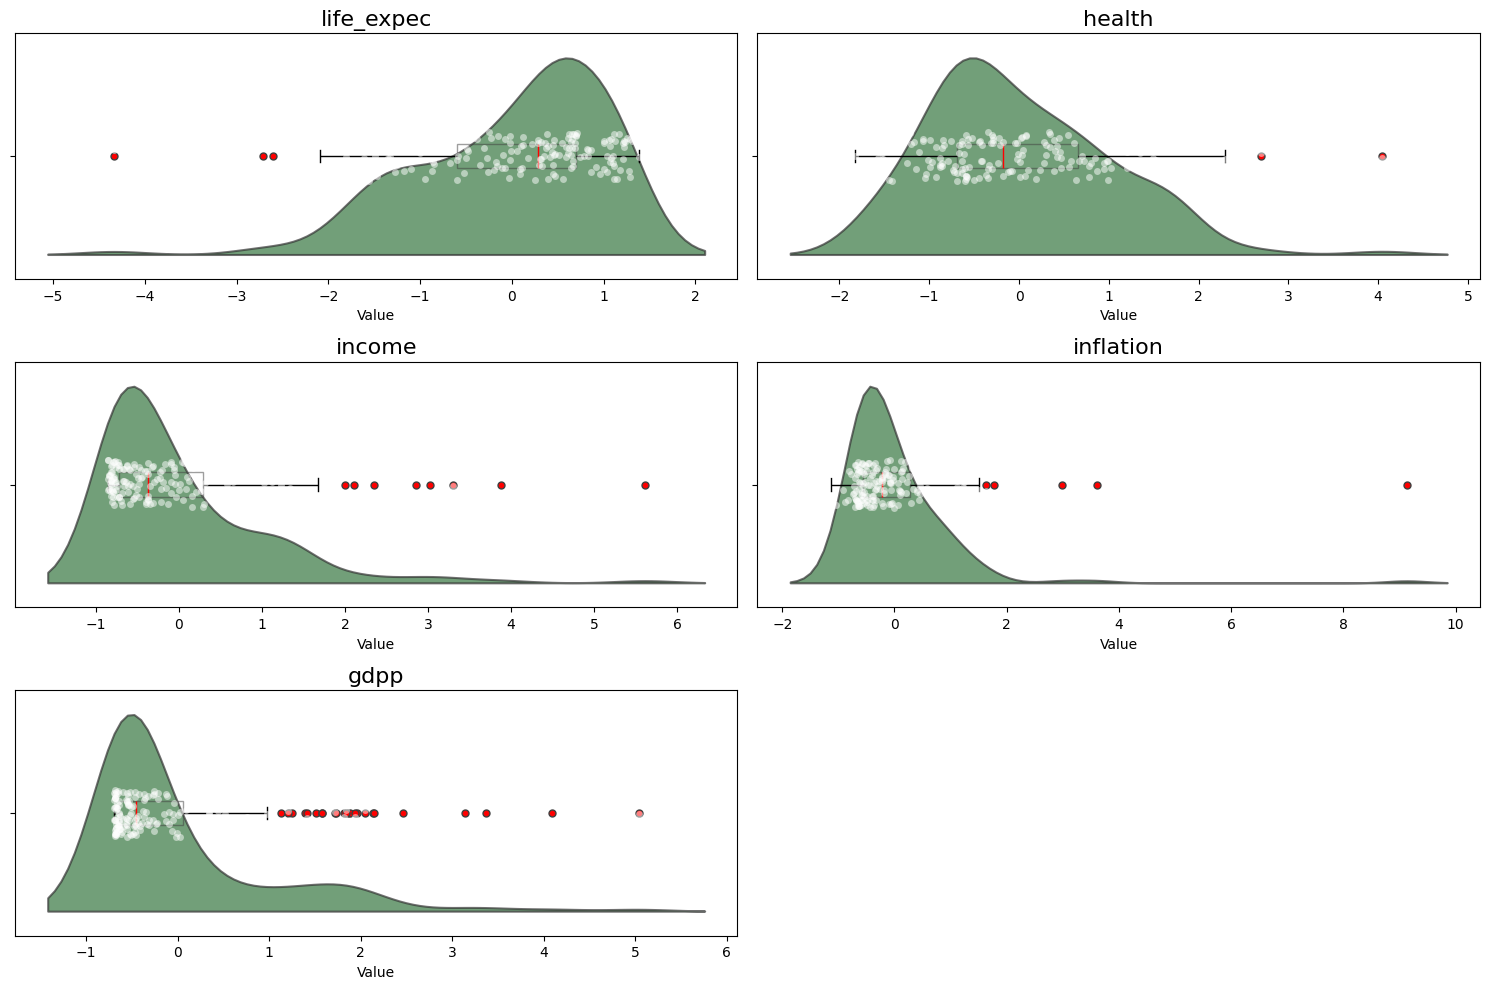

In [4]:
# Create raincloud-like plots for each variable to identify distributions and outliers
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, column in zip(axes, countries_norm.columns):
    sns.violinplot(x=countries_norm[column], orient='h', ax=ax, inner=None, color=suffled_palette[0], alpha=0.7, linewidth=1.5, split=True,)
    ax.set_ylim(top=countries_norm[column].min())
    sns.stripplot(x=countries_norm[column], orient='h', ax=ax, color='white', alpha=0.5, jitter=0.1)
    sns.boxplot(
        x=countries_norm[column], 
        orient='h', 
        ax=ax, 
        whis=1.5, 
        width=0.1, 
        boxprops=dict(facecolor='none', alpha=0.5),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        medianprops=dict(color='red'),
        flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none')
    )
    ax.set_title(column, fontsize=16)
    ax.set_xlabel('Value')

for ax in axes[len(countries_norm.columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

This visualisations reveal that most variables have a skewed distribution. For instance, income, inflation, and gdpp display significant right-skewed patterns, indicating that most countries have lower values, with a few outliers possessing much higher values. The life expectancy and health variables are more normally distributed, with a larger concentration around the mean.

The box-plot graphic highlight the presence of numerous outliers, particularly in income, inflation, and gdpp, as seen by the points outside the whiskers. This suggests that some countries have extreme values in these variables, which may need further investigation or treatment.

These visualizations provide essential insights into the spread and range of the data, helping identify skewness and the prevalence of outliers, which are crucial for determining the appropriate clustering techniques.

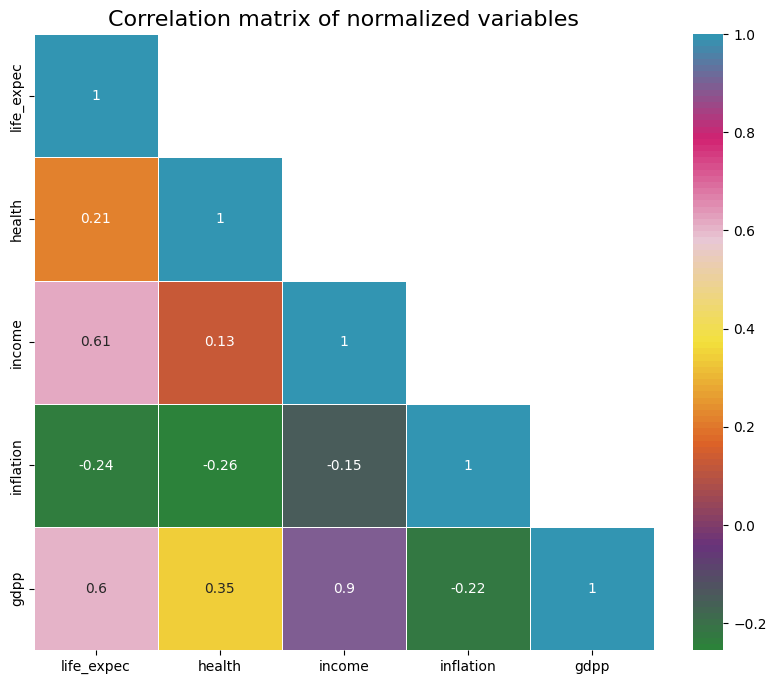

In [5]:
# Calculate the correlation matrix
correlation_matrix = countries_norm.corr()

# Mask to show only the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
cmap = continuous_cmap #it's suffled!
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, linewidths=0.5, mask=mask)
plt.title('Correlation matrix of normalized variables', fontsize=16)
plt.show()

The correlation matrix heatmap highlights **strong positive correlations**, such as **between income and gdpp (0.9)**, indicating that as income increases, GDP per capita tends to rise as well. Similarly, **life expectancy is positively correlated with both income (0.61) and gdpp (0.6)**, showing that **higher income and GDP per capita are associated with longer life expectancy.**

Interestingly, **there is a weaker correlation between life expectancy and health investment (0.21)**, suggesting that **while health investment contributes to life expectancy, it is not as strongly correlated as income or GDP**. On the other hand, **inflation exhibits a negative correlation with most variables**, particularly with life expectancy (-0.24) and health (-0.26), indicating that higher inflation is generally linked to lower life expectancy and reduced health expenditure.

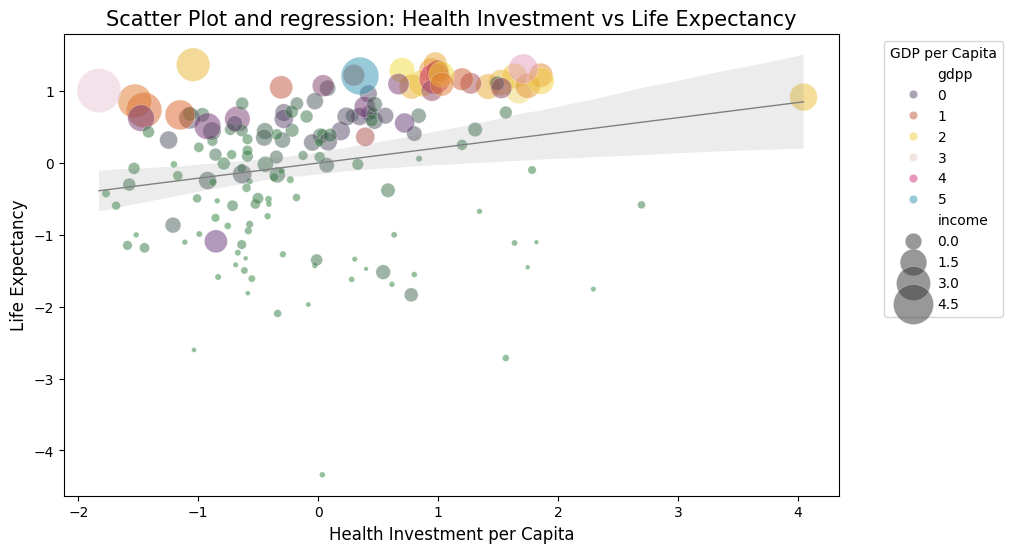

In [6]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
scatter = sns.scatterplot(
    data=countries_norm,
    x='health',
    y='life_expec',
    hue='gdpp',           # Color represents GDP per capita
    size='income',        # Size represents income
    palette= continuous_cmap,  # Using shuffled colors to enhance data visualization ethics
    sizes=(10, 1000),      # Scale of point sizes
    alpha=0.5,            # Transparency of points
    ax=ax
)
# Add regression line to scatter plot
sns.regplot(
    x=countries_norm["health"],
    y=countries_norm["life_expec"],
    scatter=False,
    line_kws={"color": "grey", "linewidth": 1},
    ax=ax
)

# Set axis labels and title
ax.set_xlabel("Health Investment per Capita", fontsize=12)
ax.set_ylabel("Life Expectancy", fontsize=12)
ax.set_title("Scatter Plot and regression: Health Investment vs Life Expectancy", fontsize=15)

# Adjust legend position
ax.legend(title='GDP per Capita', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


Like the heatmap, the scatter plot illustrates the relationship between health investment per capita and life expectancy across countries while also providing additional insights from GDP per capita and income.

The correlation between income, GDP per capita, and life expectancy observed in the heatmap is visually reinforced here. Countries with higher health investments and GDP tend to have longer life expectancies, as demonstrated by the clustering of points in the top right of the graph.
Additionally, wealthier countries are represented by larger circles, highlighting how economic strength correlates with higher health investment and life expectancy.

Each point represents a country, with its color indicating GDP per capita (ranging from darker to lighter shades) and the size of the point indicating the country's income level.

# 4. Clustering with K-means
Now we have a deep knowns of the dataset. In general terms, we know how the variables correlates with other, but furthermore we can clusterize To choose the number of clusters, we generate a plot representing the sum of squares. The configuration of the algorithm is chosen following the so-called **"Elbow Method."** This method involves creating a graph that displays the sum of squares with respect to the number of calculated clusters. Visually, you should choose where the graph makes an "elbow" in its incremental value, as explained in Anand, S. (2017).

/opt/anaconda3/envs/dataenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


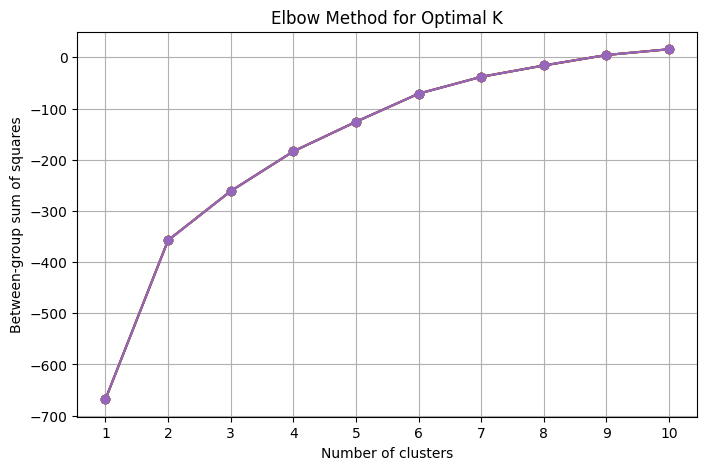

In [7]:
# Generation of a plot representing the sum of squares as a function of the number of groups
# Set random seed
np.random.seed(123) # For reproducibility

# Compute total sum of squares
total_ss = np.sum(np.square(countries_norm - np.mean(countries_norm, axis=0)))

# Initialize list to store between-cluster sum of squares
bssc = []

# Calculate between-cluster sum of squares for K from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=123).fit(countries_norm)
    within_ss = kmeans.inertia_  # Sum of squared distances to the nearest cluster center
    between_ss = total_ss - within_ss
    bssc.append(between_ss)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), bssc, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Between-group sum of squares')
plt.title('Elbow Method for Optimal K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

#print(bssc) # Used to refine the analysis but disabled to present the project with fewer distractions

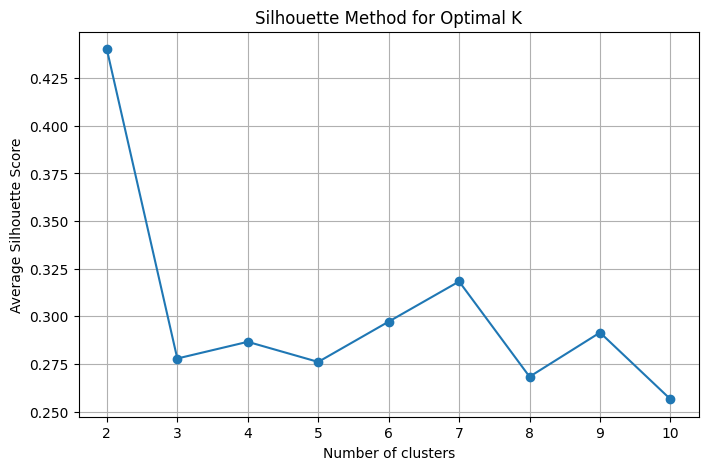

In [8]:

# Set random seed
np.random.seed(123) # For reproducibility

# Initialize list to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for K from 2 to 10
for k in range(2, 11):  # Start from 2 because silhouette score isn't defined for 1 cluster
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=123).fit(countries_norm)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(countries_norm, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

#print(silhouette_scores) # Used to refine the analysis but disabled to present the project with fewer distractions


As shown in the graphs, setting the number of clusters (K) to 7 appears to be optimal for our analysis. While fewer clusters (K) also show significant decreases, choosing **K=7** allows us to capture more detail, especially regarding the outliers identified during the EDA stage.

Additionally, this choice enables us to differentiate more effectively between countries with robust health systems and those with economic elites that may have weaker health systems but still achieve relatively good health outcomes. Thus, we opt for K=7 to provide a more nuanced analysis.

In [9]:
# Perform K-Means clustering with K=7
kmeans = KMeans(n_clusters=7, n_init=10, random_state=123).fit(countries_norm)

# Assign cluster labels to the DataFrame
countries['Cluster'] = kmeans.labels_

# Number of clusters
NumCluster = len(countries['Cluster'].unique())

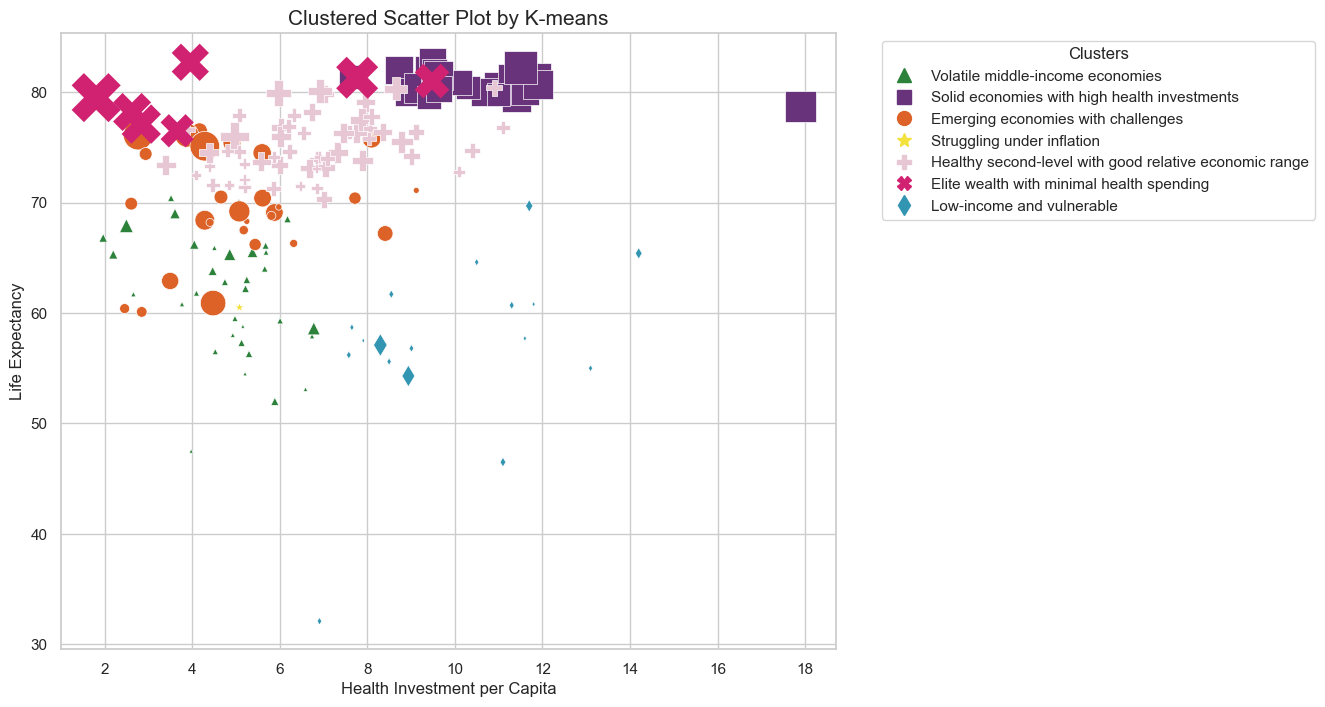

In [10]:

# Define cluster information with logical order
cluster_info = pd.DataFrame({
    'Cluster': [0, 1, 2, 3, 4, 5, 6],
    'label': [
        "Volatile middle-income economies",
        "Solid economies with high health investments",
        "Emerging economies with challenges",
        "Struggling under inflation",
        "Healthy second-level with good relative economic range",
        "Elite wealth with minimal health spending",
        "Low-income and vulnerable"


    ],
    'marker': ['o', 'd', 's', 'X', '*', '^', 'P'],
    'color': suffled_palette #Using shuffled colors to enhance data visualization aesthetics.

})

# Shuffle the markers randomly and reassign them to the DataFrame (Data Visualisation Ethics. View references on bottom of document)
markers_shuffled = cluster_info['marker'].tolist()
random.shuffle(markers_shuffled)
cluster_info['marker'] = markers_shuffled

# Merge cluster_info with countries DataFrame on 'Cluster'
countries = countries.merge(cluster_info, on='Cluster')

# Set up the Seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each cluster using the logical order
for _, row in cluster_info.iterrows():
    subset = countries[countries['Cluster'] == row['Cluster']]
    plt.scatter(
        x=subset['health'],
        y=subset['life_expec'],
        label=row['label'],
        marker=row['marker'],
        color=row['color'],
        s=subset['income'] / 100,
        edgecolor='w' if row['marker'] != 'X' else None,
        linewidth=0.5 if row['marker'] != 'X' else 0
    )


# Customising the labels and title
plt.xlabel("Health Investment per Capita", fontsize=12)
plt.ylabel("Life Expectancy", fontsize=12)
plt.title("Clustered Scatter Plot by K-means", fontsize=15)

# Creating legend handles
handles = [
    mlines.Line2D([], [], color=cluster_info.loc[i, 'color'], marker=cluster_info.loc[i, 'marker'], linestyle='None',
                  markersize=10, label=cluster_info.loc[i, 'label'])
    for i in cluster_info.index
]


# Custom legend with consistent sizes and order
plt.legend(handles=handles, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

The clustered scatter plot effectively illustrates the relationship between a country's economic status, health investment, and life expectancy. While the initial Exploratory Data Analysis (EDA) suggested a weak overall correlation between health investment and life expectancy—largely due to the dominating influence of GDP per capita and income—analyzing the clusters separately reveals a more nuanced picture.

Notably, only economic elites achieve high life expectancy despite relatively low health investment. In contrast, poor nations with significant health investment struggle to reach the life expectancy standards of wealthier countries. Additionally, not all affluent countries achieve high life expectancy without sufficient health investment. Lastly, there is a cluster representing an economy with extreme inflation, which also demonstrates poor life expectancy outcomes, underscoring the importance of economic stability.

# 5. What/where are this countries? (Mapping the life expectacy in world countries)

In [11]:

# Load Geopandas naturalearth_lowres dataset
geodata = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Clean and process geodata
geodata = clean_and_process_data(geodata)

# Display the first few rows to understand the structure
geodata.head()


/var/folders/7w/lb65cgtx7tj7nq9s6xpt_hg40000gn/T/ipykernel_27096/3419854115.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geodata = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,-0.280624,Oceania,fiji,FJI,-0.242339,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,0.097809,Africa,tanzania,TZA,-0.213694,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,-0.282524,Africa,w. sahara,ESH,-0.244618,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,-0.037463,North America,canada,CAN,0.617274,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,1.888315,North America,united states of america,USA,10.399091,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [12]:
# Merging both datasets
countries['country'] = countries['country'].str.lower().str.strip()
merged_data = geodata.merge(countries, left_on='name', right_on='country', how='left')

# Filtering columns
merged_data = merged_data[['country', 'name', 'color', 'label','health', 'gdpp', 'income', 'life_expec', 'pop_est', 'gdp_md_est', 'geometry']]

# Print merge  and countries with NA
print("Resultado del merge:")
print(merged_data.head())
print("\nPaíses con valores nulos:")
print(merged_data[merged_data.isna().any(axis=1)])




Resultado del merge:
    country                      name    color  \
0      fiji                      fiji  #2c823a   
1  tanzania                  tanzania  #2c823a   
2       NaN                 w. sahara      NaN   
3    canada                    canada  #68337b   
4       NaN  united states of america      NaN   

                                          label  health     gdpp   income  \
0              Volatile middle-income economies    4.86   3650.0   7350.0   
1              Volatile middle-income economies    6.01    702.0   2090.0   
2                                           NaN     NaN      NaN      NaN   
3  Solid economies with high health investments   11.30  47400.0  40700.0   
4                                           NaN     NaN      NaN      NaN   

   life_expec   pop_est  gdp_md_est  \
0        65.3 -0.280624   -0.242339   
1        59.3  0.097809   -0.213694   
2         NaN -0.282524   -0.244618   
3        81.3 -0.037463    0.617274   
4         NaN  1.888

In [13]:
# Identifying Mismatched Countries
missing_countries = merged_data[merged_data['country'].isna()]['name'].unique()
print("No mached countries:")
print(missing_countries)

No mached countries:
['w. sahara' 'united states of america' 'papua new guinea'
 'dem. rep. congo' 'somalia' 'dominican rep.' 'falkland is.' 'greenland'
 'fr. s. antarctic lands' 'mexico' 'nicaragua' 'honduras' 'puerto rico'
 'cuba' 'zimbabwe' "côte d'ivoire" 'central african rep.' 'congo'
 'eq. guinea' 'eswatini' 'palestine' 'laos' 'north korea' 'kyrgyzstan'
 'syria' 'new caledonia' 'solomon is.' 'taiwan' 'slovakia' 'czechia'
 'antarctica' 'n. cyprus' 'ethiopia' 'djibouti' 'somaliland'
 'bosnia and herz.' 'north macedonia' 'kosovo' 'trinidad and tobago'
 's. sudan']


In [14]:
# Building a name map
name_mapping = {
    'united states of america': 'united states',
    'papua new guinea': 'guinea',
    'dem. rep. congo': 'congo, dem. rep.',
    'dominican rep.': 'dominican republic',
    "côte d'ivoire": "cote d'ivoire",
    'central african rep.': 'central african republic',
    'congo': 'congo, rep.',
    'eq. guinea': 'equatorial guinea',
    'laos': 'lao',
    'kyrgyzstan': 'kyrgyz republic',
    'slovakia': 'slovak republic',
    'czechia': 'czech republic',
    'n. cyprus': 'cyprus',
    'bosnia and herz.': 'bosnia and herzegovina',
    'north macedonia': 'macedonia, fyr',
    's. sudan': 'south sudan'
}

# Replace new names in geodata name column
geodata['name'] = geodata['name'].replace(name_mapping)

# New merge with fixed name column
merged_data = geodata.merge(countries, left_on='name', right_on='country', how='left')

# Checking the result: I manually verified the source to confirm that there is no more data mismached. The remaining countries do not have data in the source.
missing_countries = merged_data[merged_data['country'].isna()]['name'].unique()
print("Países que no hicieron match y se perdieron:")
print(missing_countries)

Países que no hicieron match y se perdieron:
['w. sahara' 'somalia' 'falkland is.' 'greenland' 'fr. s. antarctic lands'
 'mexico' 'nicaragua' 'honduras' 'puerto rico' 'cuba' 'zimbabwe'
 'eswatini' 'palestine' 'north korea' 'syria' 'new caledonia'
 'solomon is.' 'taiwan' 'antarctica' 'ethiopia' 'djibouti' 'somaliland'
 'kosovo' 'trinidad and tobago' 'south sudan']


In [15]:
# Creating a folium map
map = fl.Map(location=[20, 0], zoom_start=2, tiles='CartoDB positron')

# Adding country data
for _, row in merged_data.iterrows():
    # Adding gray color for countries without data
    color = row['color'] if 'color' in row and pd.notna(row['color']) else '#E6E6E6'  # Gris claro para países sin datos
    
    fill_opacity = min(max((row['life_expec'] - 30) / 50, 0.1), 0.9)  # Opacity sensitive to life expectancy data
    geo_json = {
        'type': 'Feature',
        'geometry': row['geometry'].__geo_interface__,
        'properties': {
            'name': row['country'],
            'Cluster': row.get('label', 'No Cluster'),
            'health': row.get('health', 'N/A'),
            'gdpp': row.get('gdpp', 'N/A'),
            'income': row.get('income', 'N/A'),
            'life_expec': row.get('life_expec', 'N/A')
        }
    }
    fl.GeoJson(
        data=geo_json,
        style_function=lambda feature, color=color, fill_opacity=fill_opacity: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': fill_opacity,
        },
        tooltip=fl.GeoJsonTooltip(
            fields=['name', 'Cluster', 'health', 'gdpp', 'income', 'life_expec'],
            aliases=['Country', 'Cluster', 'Per capita Health Spending (% of GDP per capita)', 'GDP per capita in $', 'Income AVG $', 'Life Expectancy']
        )
    ).add_to(map)

    # Create the HTML legend using the colors and labels from the cluster_info DataFrame
legend_html = '<div style="position: fixed; bottom: 20px; right: 10px; width: 350px; height: auto; background-color: white; z-index:9999; font-size:11px; border:2px solid grey; padding: 10px;">'
legend_html += '<b>Legend</b><br>'
for _, row in cluster_info.iterrows():
    legend_html += f'<i style="background: {row["color"]}; width: 10px; height: 10px; border-radius: 50%; display: inline-block;"></i> {row["label"]}<br>'
# Añadir la categoría gris para los países sin datos
legend_html += '<i style="background: #E6E6E6; width: 10px; height: 10px; border-radius: 50%; display: inline-block;"></i> There is no data available in the source<br>'
legend_html += '</div>'
map.get_root().html.add_child(fl.Element(legend_html))

# Saving and showing the map
map.save("clustered_countries_map.html")
map  # This code displays the map in an interactive environment like Jupyter Notebook, but it won’t work on GitHub. Therefore, a snapshot of the map is attached to the GitHub repository.

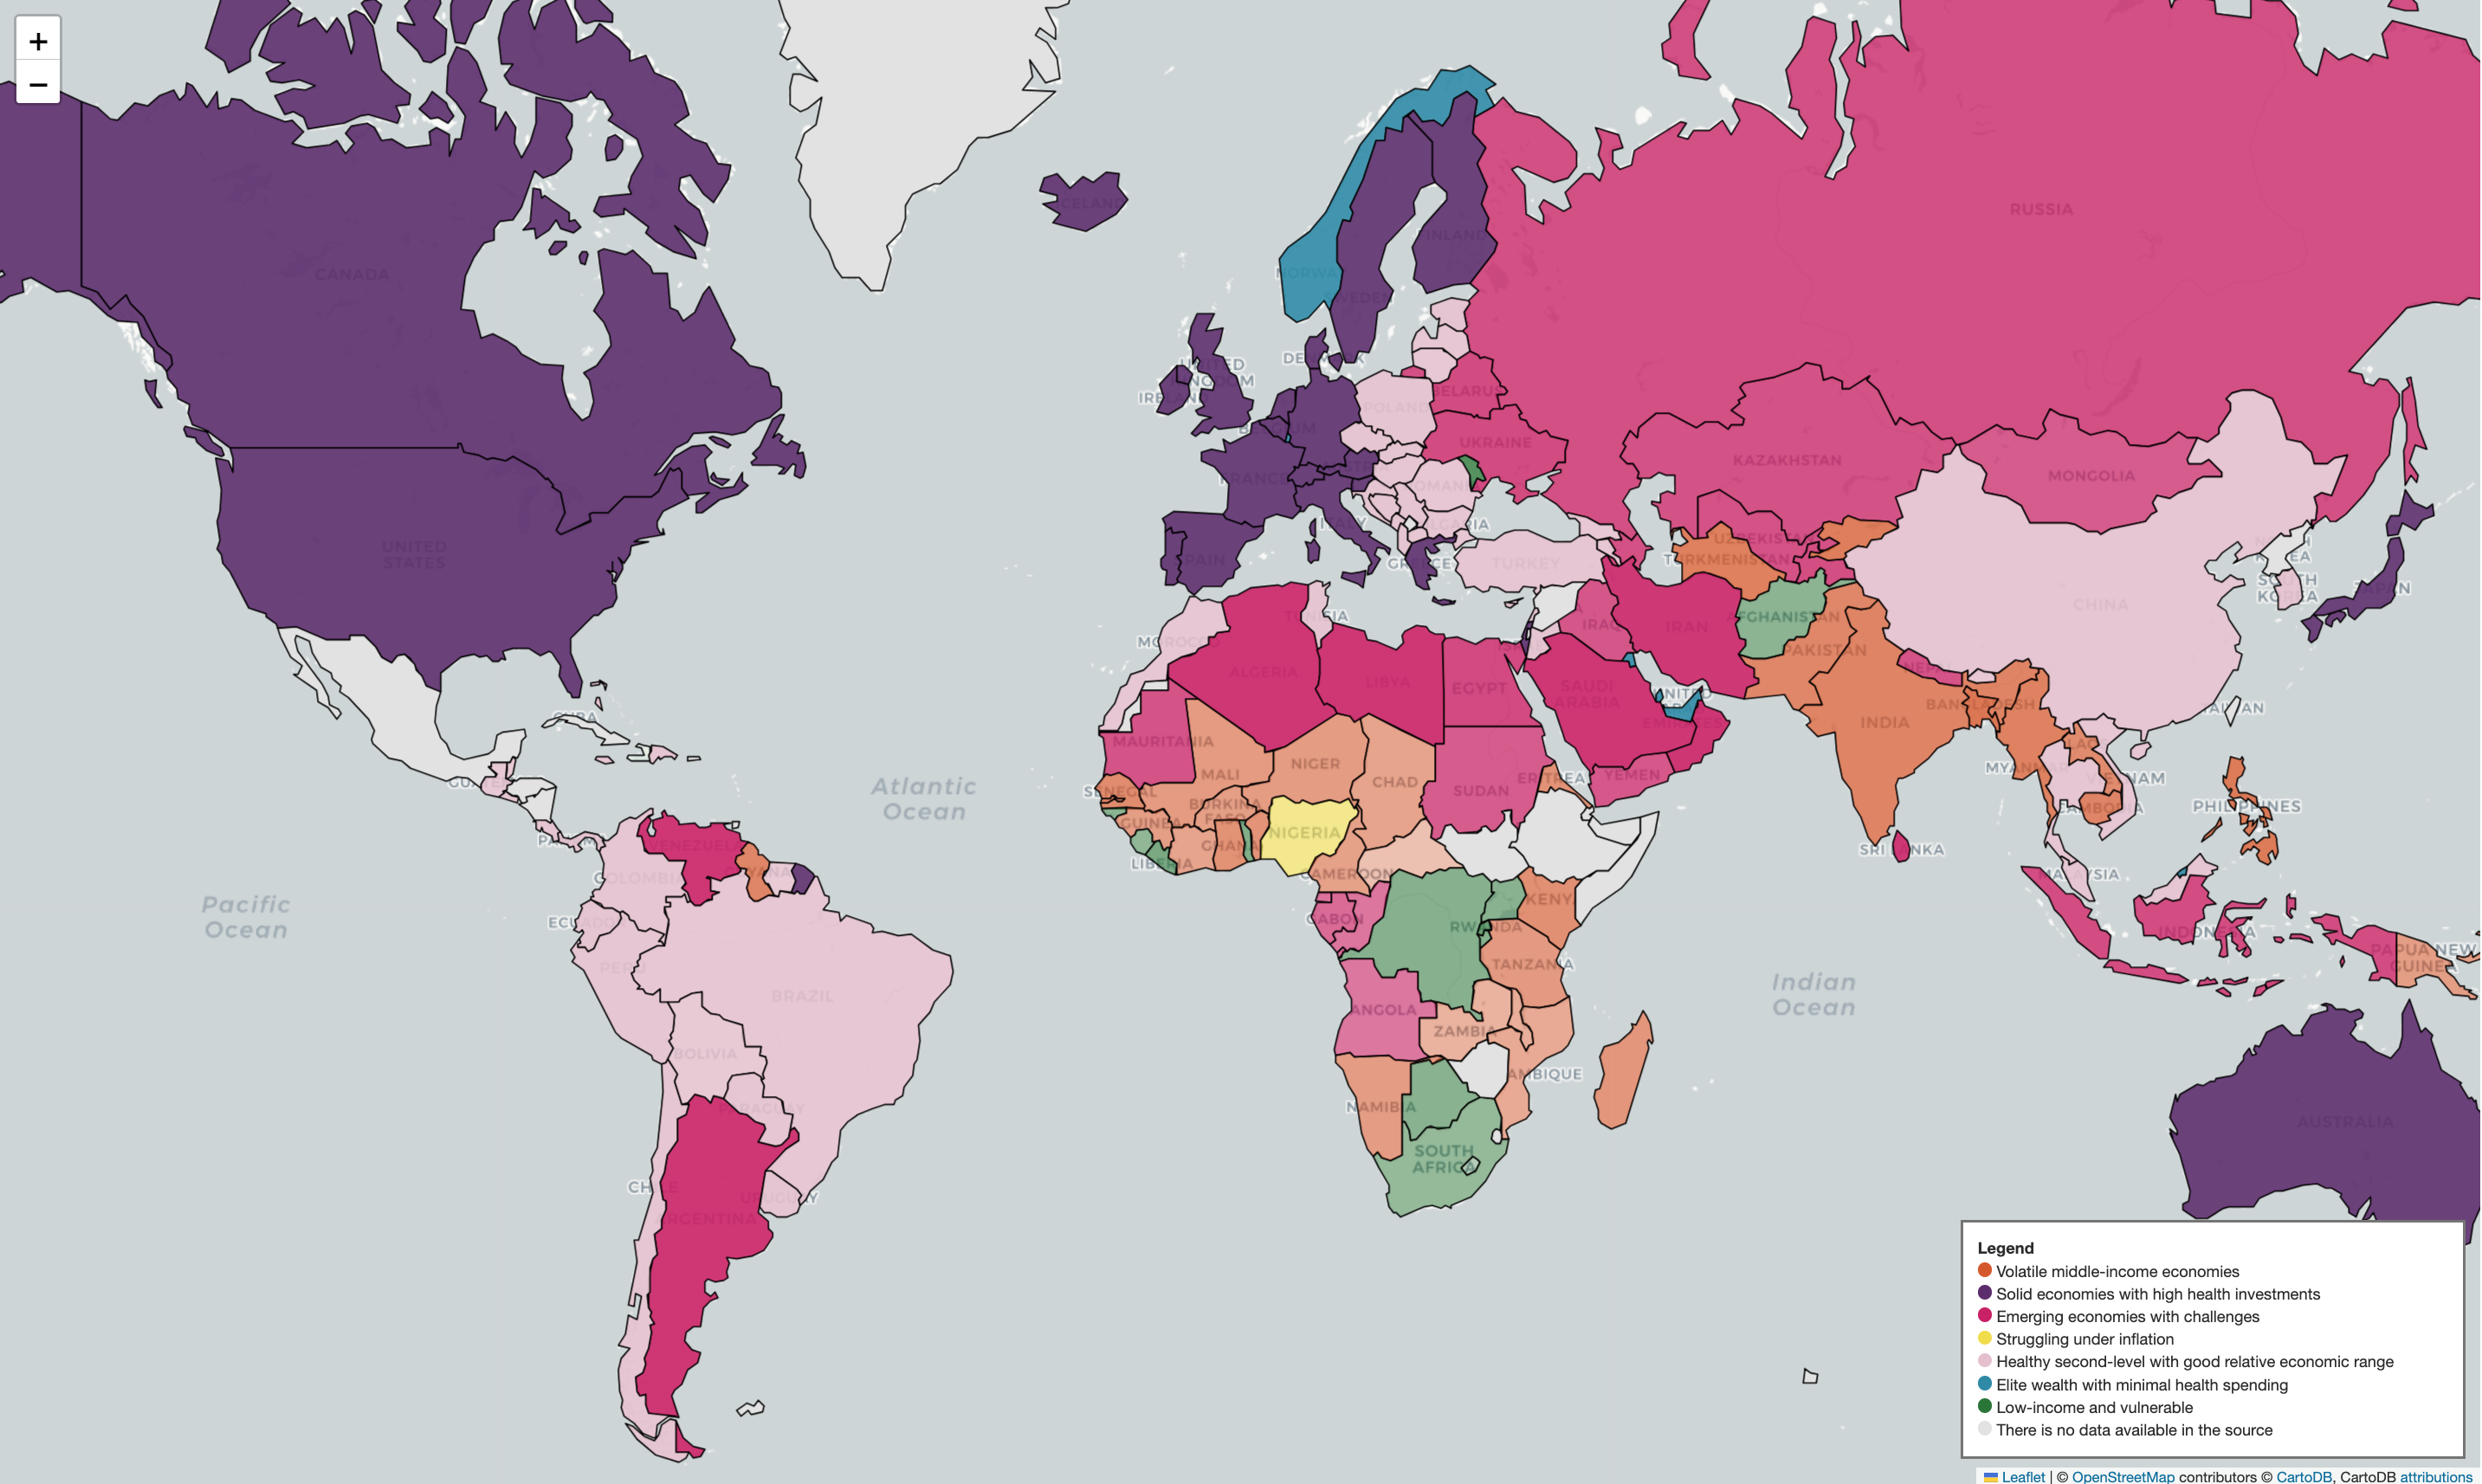

In [16]:
# Display image for GitHub repository result demonstration
from IPython.display import Image, display

display(Image(filename="clustered_countries_map.png"))

The map visually represents each country, color-coded according to its assigned cluster. 
Insights:

**Solid economies with high health investments** are predominantly clustered in Europe, North America, and parts of East Asia, reflecting their significant investment in health infrastructure.

**Healthy second-level with good relative economic range** are more dispersed, found in both developed and developing regions, indicating a diverse range of economic and health outcomes.

**Elite wealth with minimal health spending** are notably concentrated in wealthier regions, particularly in countries with high GDP per capita, where wealth compensates for lower health investments.

**Emerging economies with challenges** are primarily located in Africa and parts of South Asia, where lower health investments and economic challenges contribute to lower life expectancy.

**Volatile middle-income economies** are scattered across Eastern Europe, Central Asia, and some parts of Latin America, reflecting the economic and health transitions these countries are undergoing.

**Low-income and vulnerable** are mostly in Africa, where despite efforts in health spending, other factors such as poverty and instability hinder improvements in life expectancy.

**Struggling under inflation** is represented by very few countries, highlighted with a
red color, underscoring the economic challenges these nations face that severely impact their overall health and economic stability.

Hovering over any point on the map reveals a pop-up box displaying the country's name, its corresponding country code, and a brief description of its cluster. This interactive feature allows users to easily identify and understand the distribution of different economic and health investment profiles across the globe.

# 6. References

Anand, S. (2017) *Finding Optimal Number of Clusters*. R Bloggers, 9 February. Available at: [https://www.r-bloggers.com/2017/02/finding-optimal-number-of-clusters/] [Accessed: May 2024].

Bruce, P., Bruce, A. & Gedeck, P. (2020) *Practical Statistics for Data Scientists*. 2nd edn. O’Reilly Media, Inc.

Gapminder. (n.d.) *Gapminder Data Project*. Available at: [https://www.gapminder.org/] [Accessed: May 2024].

Gironés Roig, J. (2016) *Business Analytics: Análisis de datos para organizaciones*. Edited by M. Pujol Jover. Editorial UOC.

Gironés Roig, J., Casas Roma, J., Minguillón Alfonso, J. & Caihuelas Quiles, R. (2017) *Minería de datos: Modelos y algoritmos*. Editorial UOC.

Muth, L.C. (2024) *What to consider when choosing colors for race, ethnicity, and world regions*. Available at: https://blog.datawrapper.de/colors-for-race-ethnicity-world-regions/ [Accessed 16 November 2024].

TedTalks. (n.d.) *Global health expert; data visionary*. Available at: [https://www.ted.com/speakers/hans_rosling](https://www.ted.com/speakers/hans_rosling) [Accessed: May 2024].

Wu, X., Kumar, V., Ross Quinlan, J., Ghosh, J., Motoda, H., McLachlan, G., Ng, A., Liu, B., Yu, P. S., Zhou, Z.-H., Steinbach, M., Hand, D. J., Steinberg, D. & Yang, Q. (2008) 'Top 10 algorithms in data mining', *Knowledge and Information Systems*, 14(1), pp. 1–37. https://doi.org/10.1007/s10115-007-0114-2

Yuan, C. & Yang, H. (2019) 'Research on K-Value Selection Method of K-Means Clustering Algorithm', *Journal*, 2, pp. 226-235. https://doi.org/10.3390/j2020016